In [55]:
!pip install streamlit pyngrok transformers torchvision torch opencv-python matplotlib seaborn pillow googletrans==4.0.0-rc1 gtts

In [56]:
from google.colab import drive
drive.mount('/content/drive')

IMG_DIR = "/content/drive/MyDrive/COCO DATASET (1)/val2017/val2017"
CAPTIONS_JSON = "/content/drive/MyDrive/COCO DATASET (1)/annotations/captions_val2017.json/captions_val2017.json"
INSTANCES_JSON = "/content/drive/MyDrive/COCO DATASET (1)/annotations/captions_val2017.json/instances_val2017.json/instances_val2017.json"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


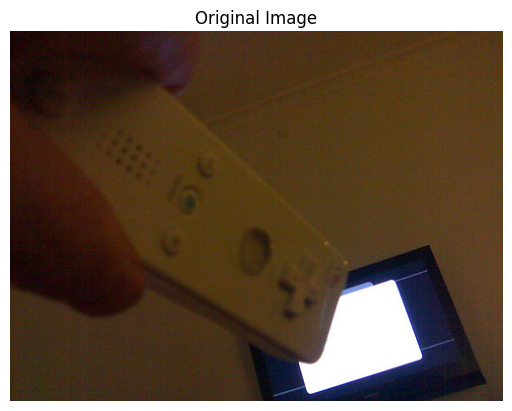

📂 Image ID: 533145
📜 Human Captions:
1. A hand holding a Nintendo Wii game controller.
2. Someone holding a Wii remote towards a TV.
3. a person pointing a wii controller at a computer screen
4. A video game controller being pointed at a television.
5. A person holding a wii controller for video game.


In [57]:
from pycocotools.coco import COCO
import os, cv2, random
import matplotlib.pyplot as plt
from PIL import Image

coco_caps = COCO(CAPTIONS_JSON)

img_id = random.choice(coco_caps.getImgIds())

img_info = coco_caps.loadImgs(img_id)[0]
img_path = os.path.join(IMG_DIR, img_info['file_name'])

img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

ann_ids = coco_caps.getAnnIds(imgIds=img_id)
anns = coco_caps.loadAnns(ann_ids)
print(f"📂 Image ID: {img_id}")
print("📜 Human Captions:")
for i, ann in enumerate(anns):
    print(f"{i+1}. {ann['caption']}")



In [58]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)



In [59]:
from torchvision import models, transforms

from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

weights = DeepLabV3_ResNet50_Weights.DEFAULT
seg_model = models.segmentation.deeplabv3_resnet50(weights=weights).eval()


In [60]:
VOC_LABELS = {
    0: "background", 1: "aeroplane", 2: "bicycle", 3: "bird", 4: "boat", 5: "bottle",
    6: "bus", 7: "car", 8: "cat", 9: "chair", 10: "cow", 11: "diningtable", 12: "dog",
    13: "horse", 14: "motorbike", 15: "person", 16: "potted plant", 17: "sheep",
    18: "sofa", 19: "train", 20: "tvmonitor"
}


In [61]:
def analyze_image(img_path, coco_caps, caption_model, caption_processor, seg_model, voc_labels):
    import os, cv2
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    from torchvision import transforms
    import seaborn as sns

    # Load and convert image
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img).convert("RGB")

    # Generate Caption
    inputs = caption_processor(images=pil_img, return_tensors="pt").to(caption_model.device)
    output = caption_model.generate(**inputs)
    caption = caption_processor.decode(output[0], skip_special_tokens=True)

    # Segment Image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = transform(pil_img).unsqueeze(0)
    with torch.no_grad():
        seg_output = seg_model(input_tensor)['out'][0]
    segmentation = seg_output.argmax(0)

    # Show Image + Segmentation
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(pil_img)
    plt.axis('off')
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation.cpu(), cmap='tab20b')
    plt.axis('off')
    plt.title("Segmentation Mask")
    plt.suptitle(f"📜 Caption: {caption}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Pixel Count Bar Plot
    unique_classes, counts = np.unique(segmentation.numpy(), return_counts=True)
    plt.figure(figsize=(12, 4))
    sns.barplot(x=unique_classes, y=counts, palette="viridis")
    plt.xlabel("Class Label ID")
    plt.ylabel("Pixel Count")
    plt.title("Detected Segmentation Classes (by pixel area)")
    plt.show()

    # Print Labels
    print("🧠 Classes present in the image:")
    for cls_id in unique_classes:
        if cls_id in voc_labels:
            pixel_count = counts[np.where(unique_classes == cls_id)][0]
            print(f" - {voc_labels[cls_id]} (Label {cls_id}, Pixels: {pixel_count})")

    print("🎯 Top object in segmentation:", voc_labels.get(int(unique_classes[np.argmax(counts)]), "unknown"))
    print("🔍 Caption from BLIP:", caption)

    return caption


/tmp/ipython-input-61-696283699.py:44: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


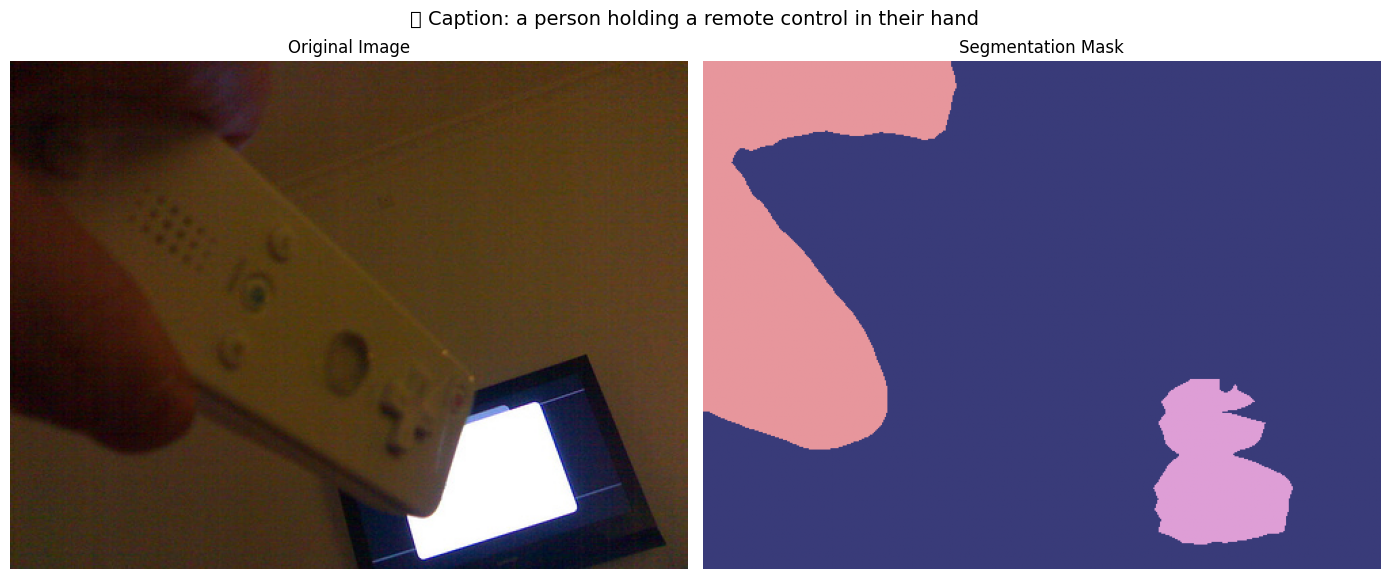

/tmp/ipython-input-61-696283699.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_classes, y=counts, palette="viridis")


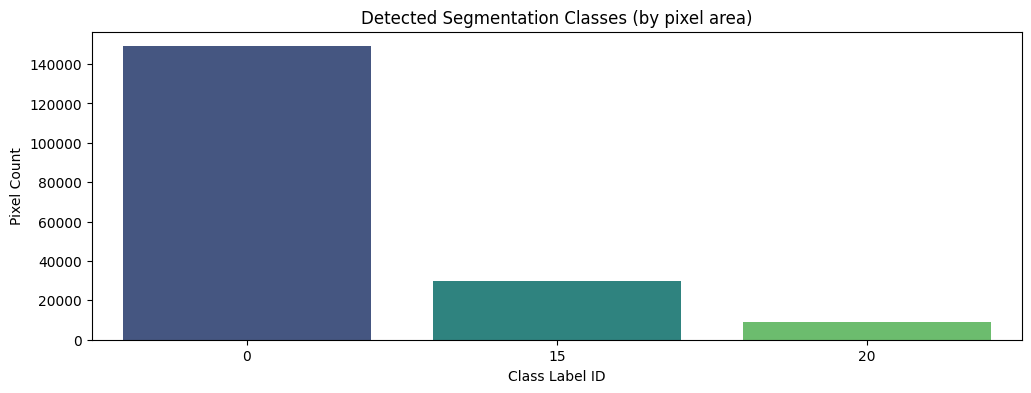

🧠 Classes present in the image:
 - background (Label 0, Pixels: 149006)
 - person (Label 15, Pixels: 29702)
 - tvmonitor (Label 20, Pixels: 8792)
🎯 Top object in segmentation: background
🔍 Caption from BLIP: a person holding a remote control in their hand


In [62]:

# Call the function
caption_result = analyze_image(
    img_path=img_path,
    coco_caps=coco_caps,
    caption_model=caption_model,
    caption_processor=processor,
    seg_model=seg_model,
    voc_labels=VOC_LABELS
)



🔎 Analyzing Image ID: 35279


/tmp/ipython-input-61-696283699.py:44: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


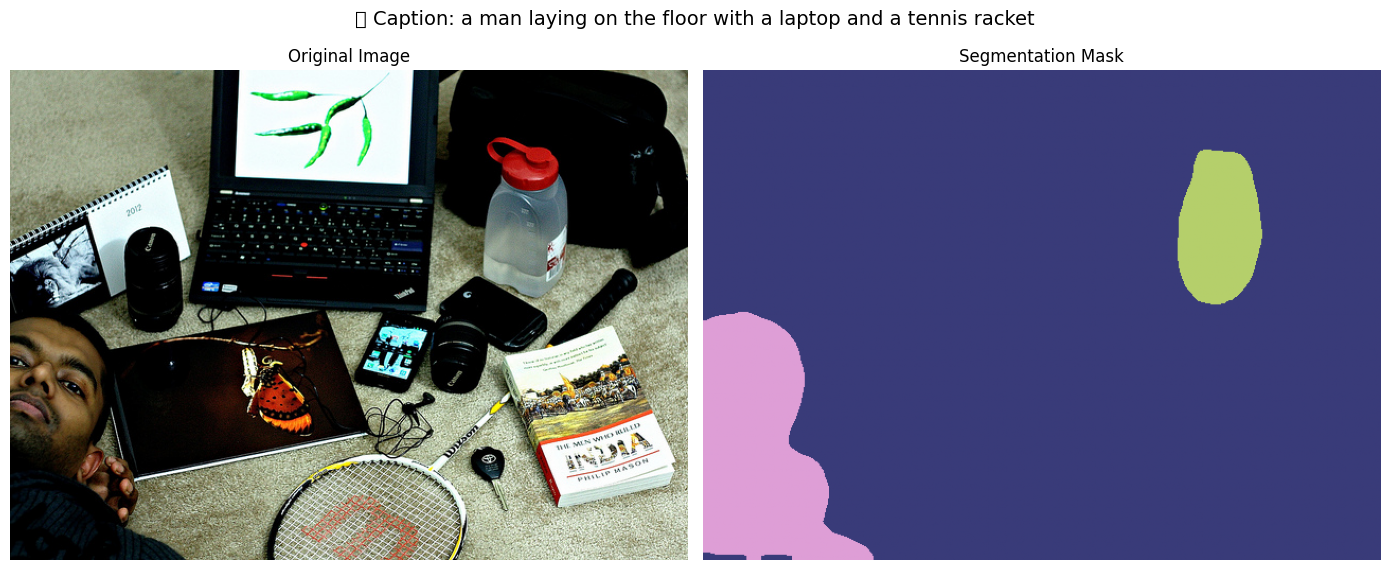

/tmp/ipython-input-61-696283699.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_classes, y=counts, palette="viridis")


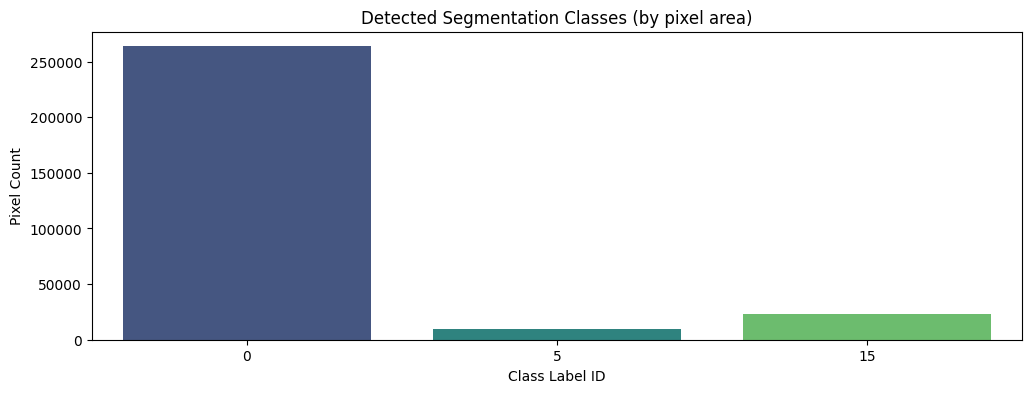

🧠 Classes present in the image:
 - background (Label 0, Pixels: 263670)
 - bottle (Label 5, Pixels: 9290)
 - person (Label 15, Pixels: 23360)
🎯 Top object in segmentation: background
🔍 Caption from BLIP: a man laying on the floor with a laptop and a tennis racket

🔎 Analyzing Image ID: 76211


/tmp/ipython-input-61-696283699.py:44: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


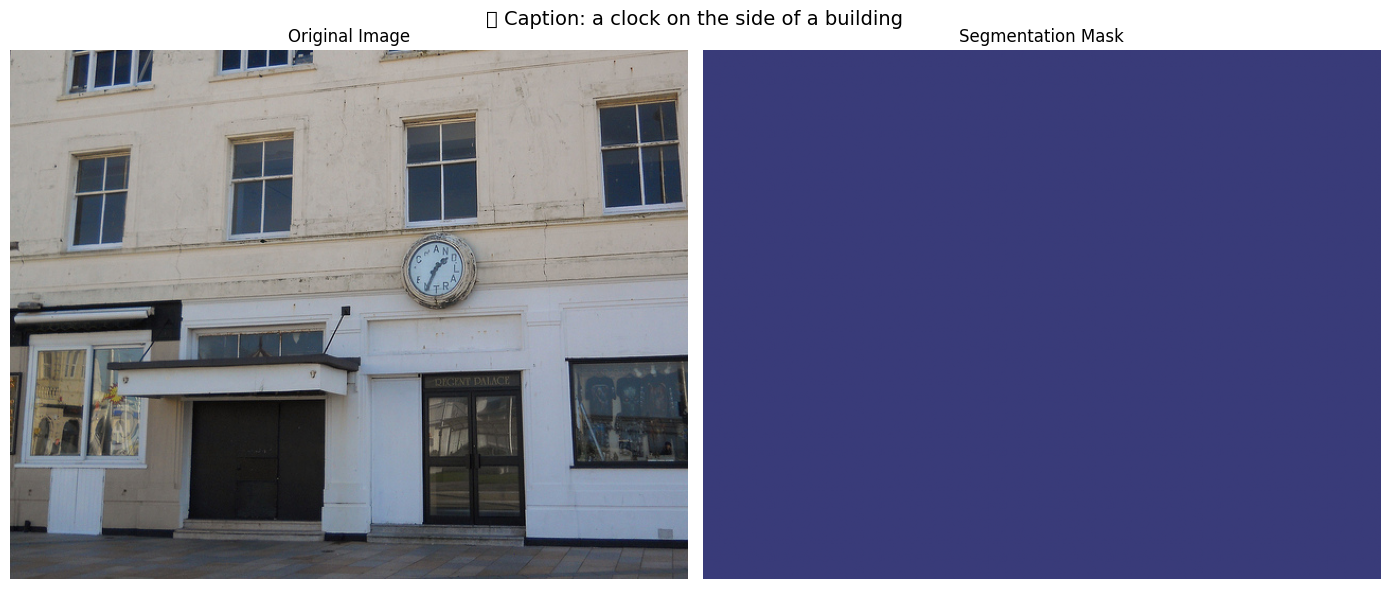

/tmp/ipython-input-61-696283699.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_classes, y=counts, palette="viridis")


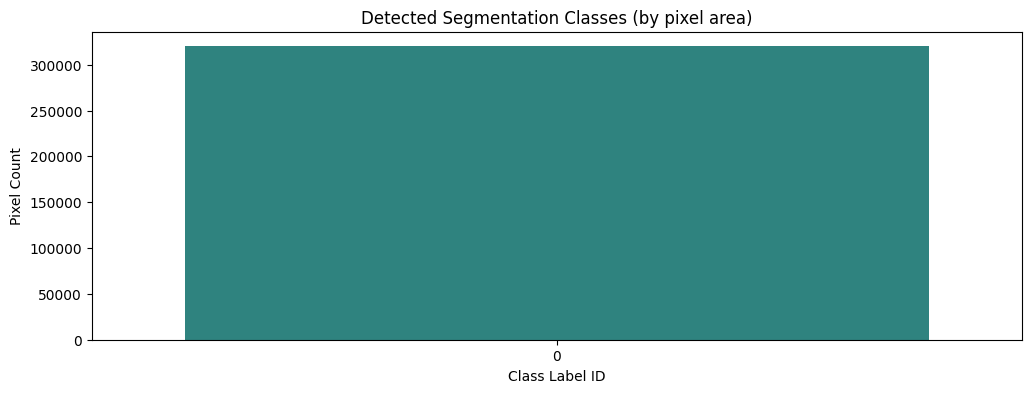

🧠 Classes present in the image:
 - background (Label 0, Pixels: 320000)
🎯 Top object in segmentation: background
🔍 Caption from BLIP: a clock on the side of a building

🔎 Analyzing Image ID: 207585


/tmp/ipython-input-61-696283699.py:44: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


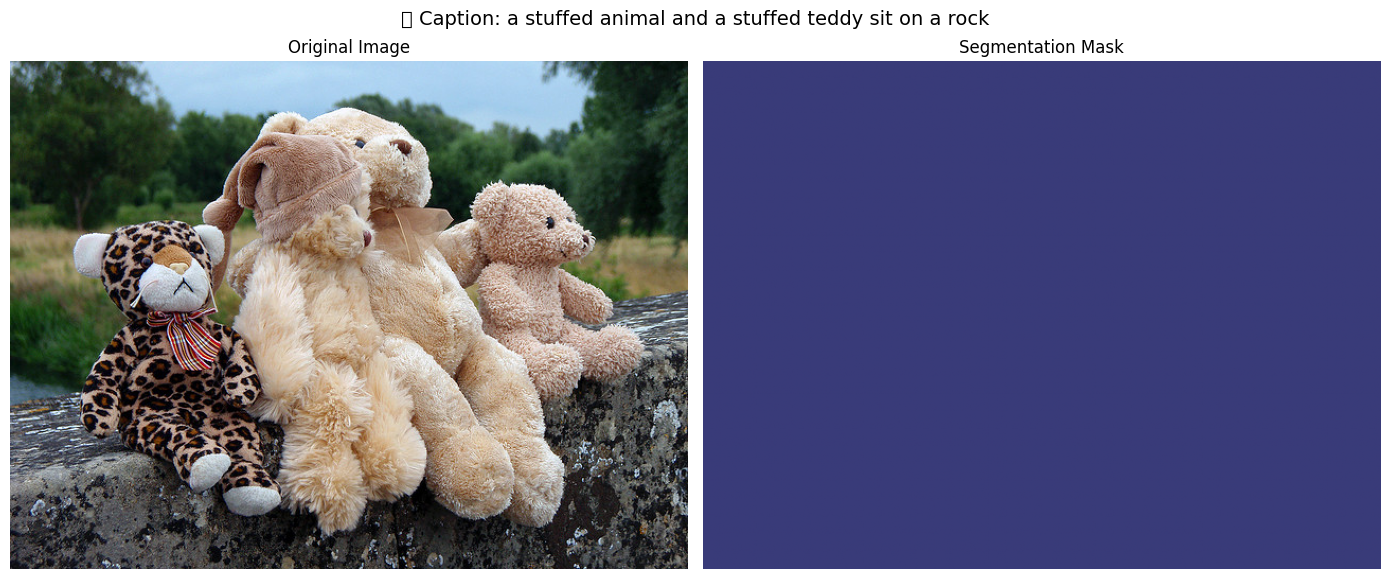

/tmp/ipython-input-61-696283699.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_classes, y=counts, palette="viridis")


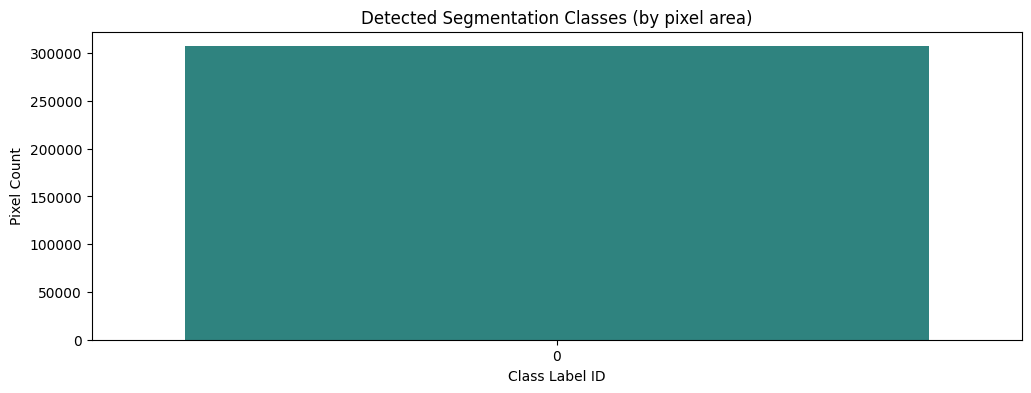

🧠 Classes present in the image:
 - background (Label 0, Pixels: 307200)
🎯 Top object in segmentation: background
🔍 Caption from BLIP: a stuffed animal and a stuffed teddy sit on a rock


In [63]:
img_ids = coco_caps.getImgIds()
for img_id in random.sample(img_ids, 3):  # Pick 3 random images
    img_info = coco_caps.loadImgs(img_id)[0]
    path = os.path.join(IMG_DIR, img_info['file_name'])
    print(f"\n🔎 Analyzing Image ID: {img_id}")
    analyze_image(path, coco_caps, caption_model, processor, seg_model, VOC_LABELS)


In [139]:
!ngrok config add-authtoken 2zlqGZOeoetw5MKfbaS87izpHM9_4RMnNs8sqv8dVSy7vf5dZ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [140]:
app_code = '''
import streamlit as st
import torch
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from gtts import gTTS
from io import BytesIO
from googletrans import Translator
from torchvision import models, transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
from transformers import BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt
import streamlit.components.v1 as components

# Load models
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cpu").eval()
seg_model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT).eval()

VOC_LABELS = {
    0: "background", 1: "aeroplane", 2: "bicycle", 3: "bird", 4: "boat", 5: "bottle",
    6: "bus", 7: "car", 8: "cat", 9: "chair", 10: "cow", 11: "diningtable", 12: "dog",
    13: "horse", 14: "motorbike", 15: "person", 16: "potted plant", 17: "sheep",
    18: "sofa", 19: "train", 20: "tvmonitor"
}

def analyze(image_pil):
    image_np = np.array(image_pil.convert("RGB"))

    # Captioning
    inputs = processor(images=image_pil, return_tensors="pt")
    output = caption_model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)

    # Segmentation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    tensor = transform(image_pil).unsqueeze(0)
    with torch.no_grad():
        out = seg_model(tensor)['out'][0]
    mask = out.argmax(0).numpy()

    # Stats
    classes, counts = np.unique(mask, return_counts=True)
    data = [{"Label": VOC_LABELS.get(int(c), "unknown"), "Pixels": int(p)} for c, p in zip(classes, counts) if c in VOC_LABELS]
    df = pd.DataFrame(data).sort_values("Pixels", ascending=False)

    # Overlay
    mask_overlay = np.zeros_like(image_np)
    mask_overlay[:, :, 1] = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]))
    mask_overlay = (mask_overlay / mask_overlay.max() * 255).astype(np.uint8)
    overlay = cv2.addWeighted(image_np, 0.7, mask_overlay, 0.3, 0)

    dominant = df.iloc[0]["Label"] if not df.empty else "unknown"
    return caption, overlay, df, dominant

components.html("""
<div style="
    padding: 30px;
    background: linear-gradient(to bottom, #07B9CE, #3969E7, #7D2AE7);
    border-radius: 20px;
    box-shadow: 0 4px 20px rgba(0,0,0,0.15);
    margin-bottom: 30px;
    text-align: center;
    color: white;
">
  <h1 style="
    font-family: 'Poppins', sans-serif;
    font-size: 40px;
    margin-bottom: 10px;
  ">🎨 Vision AI Studio</h1>
  <p style="
    font-size: 18px;
    font-family: 'Poppins', sans-serif;
  ">Upload an image to see automatic captioning and segmentation</p>
</div>
""", height=200)

# ------------------ Streamlit Interface ------------------
uploaded_file = st.file_uploader("📁 Upload Image", type=["jpg", "jpeg", "png"])
lang = st.selectbox("🌍 Translate Caption To", ["en", "hi", "ta", "fr", "es", "te", "kn", "ml", "zh-cn"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    if st.button("✨ Analyze with Our AI"):
        with st.spinner("Analyzing..."):
            caption, overlay_img, df, dominant = analyze(image)

            # Translate caption
            translator = Translator()
            translated = translator.translate(caption, dest=lang).text

            # Text-to-speech
            tts = gTTS(text=translated, lang=lang)
            audio_fp = BytesIO()
            tts.write_to_fp(audio_fp)
            audio_fp.seek(0)

            # Display results
            st.markdown("## Segmentation Overlay")
            st.image(overlay_img, caption="Overlay Image", use_column_width=True)

            st.markdown("## 📝 Caption")

            st.markdown("## 📊 Pixel Distribution")
            st.dataframe(df)

            fig, ax = plt.subplots()
            ax.barh(df["Label"], df["Pixels"], color="#7D2AE7")
            ax.set_xlabel("Pixel Count")
            ax.set_title("Pixel Distribution")
            st.pyplot(fig)


            st.success(translated)

            st.audio(audio_fp, format="audio/mp3")



'''

with open("app.py", "w") as f:
    f.write(app_code)


In [141]:
# This will terminate all ngrok processes
import os
os.system("pkill -f ngrok")

print("✅ All ngrok tunnels have been stopped. Now you can restart your tunnel.")


✅ All ngrok tunnels have been stopped. Now you can restart your tunnel.


In [142]:
from pyngrok import ngrok
!streamlit run app.py &>/dev/null &
public_url = ngrok.connect(8501)
print("🔗 Click here to open your app:", public_url)



🔗 Click here to open your app: NgrokTunnel: "https://1a99fb7514b2.ngrok-free.app" -> "http://localhost:8501"
